In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Data

This work will use data from Electric Insights (kindly pulled from their undercover API by Ayrton Bourn). The analysis will be based on 2019, the last year of complete data excluding 2020, which was unusual due to the pandemic. 

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_2019.csv')

In [3]:
df['local_datetime'] = pd.to_datetime(df.local_datetime, utc=True)
df = df.set_index('local_datetime')
df = df.sort_index()

# Drop NAs for demand and carbon intensity
df = df.dropna(subset=['demand', 'gCO2_per_kWh'], axis=0)

# Add some datetime features
df['net_demand'] = df.demand - df.wind - df.solar
df['hour'] = df.index.hour
df['month'] = df.index.month - 1
df['dayofyear'] = df.index.dayofyear
df['sin_hour'] = np.sin(2*np.pi*df.hour / 24)
df['cos_hour'] = np.cos(2*np.pi*df.hour / 24)

### Checking for Outliers

Text(0, 0.5, 'gCO2 per kWh')

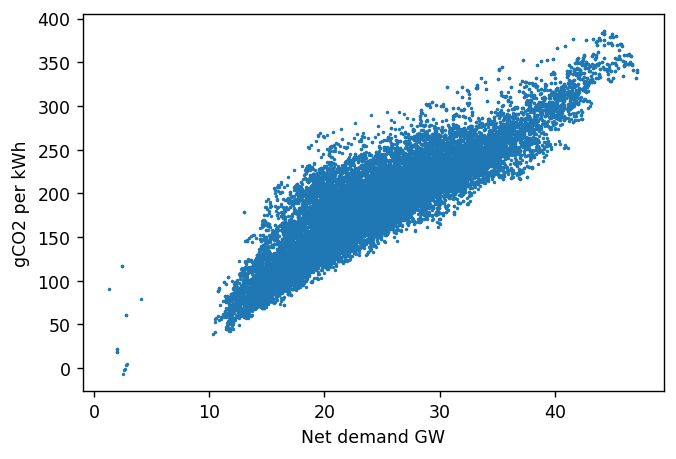

In [4]:
fig, ax = plt.subplots(dpi=125)
ax.scatter(df.net_demand, df.gCO2_per_kWh, s=1)
ax.set_xlabel('Net demand GW')
ax.set_ylabel('gCO2 per kWh')

Remove those outliers:

In [5]:
df = df[df.net_demand > 5]

There is a fairly clear relationship between net demand and gCO2 per kWh, but also a huge amount of noise. The carbon intensity for a net demand of 25 GW can be anywhere between ~130--300gCO2/kWh. This does not give us a great signal! 

Panelling by hour gives a picture of the changing relationship between demand and CO2 intensity through the day:

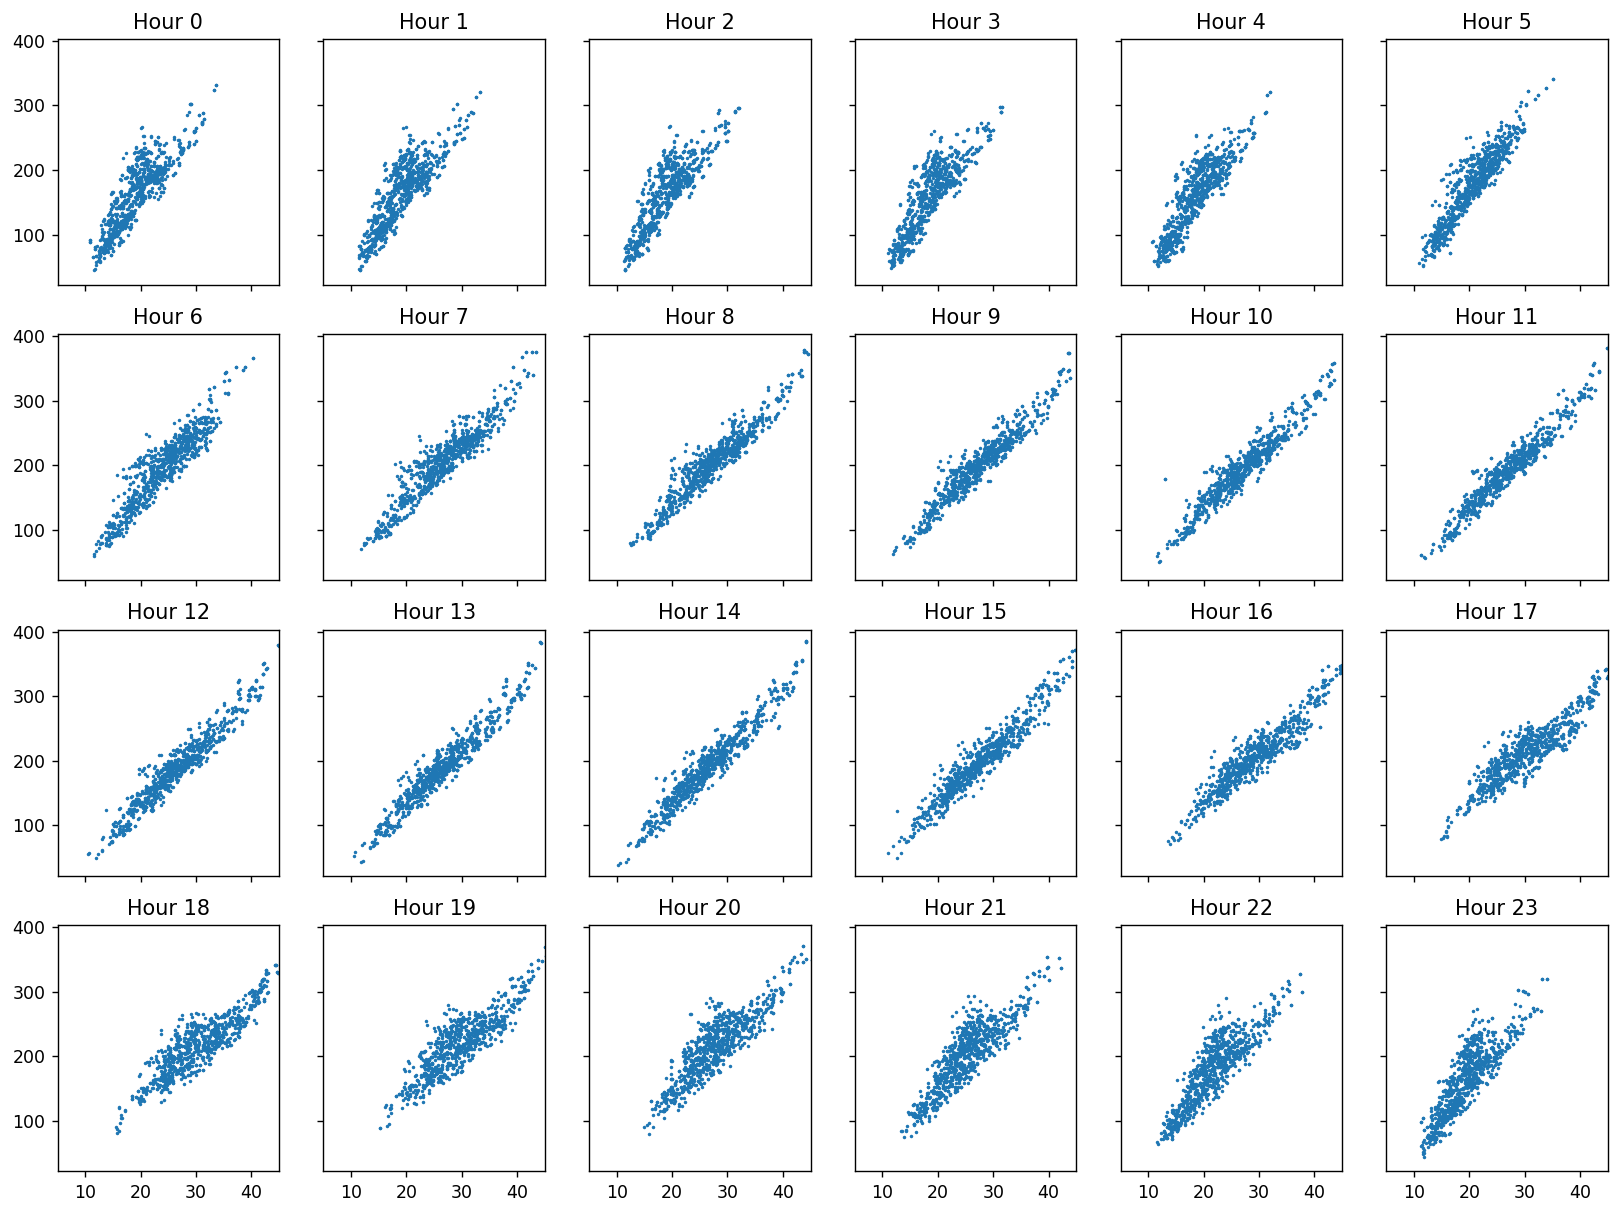

In [6]:
fig, axs = plt.subplots(4,6, dpi=125, figsize=(16,12), sharey=True, sharex=True)

rs = []
for i, ax in enumerate(axs.flatten()): 
    split = df.loc[df.index.hour == i].copy()
    
    ax.scatter(split.net_demand, split.gCO2_per_kWh, s=1)
    ax.set_title("Hour {}".format(i))
    ax.set_xlim(5, 45)
    
    r = stats.pearsonr(split.net_demand, split.gCO2_per_kWh)
    rs.append(r[0])
    
    

There is a much clearer relationship now if we control for hour (note binned approaches to CO2 intensity prediciton from the Wattime report). CO2 intensity is most strongly correlated with demand during daytime hours:

Text(0, 0.5, 'Pearson R')

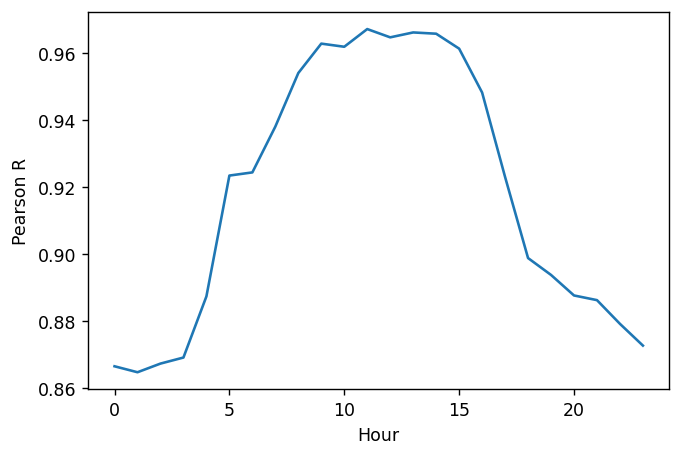

In [7]:
fig, ax = plt.subplots(dpi=125)

ax.plot(rs)
ax.set_xlabel('Hour')
ax.set_ylabel('Pearson R')

### GAMs

In this prototype we will apply generalised additive models (GAMs) to fit CO2 intensity against net demand and other power system variables.

In [8]:
from pygam import LinearGAM, s, f

Helper function to split the data into target (carbon intensity) and features:

In [9]:
def get_X_y(df, feature_cols):
    y = df['gCO2_per_kWh'].values.reshape(-1,)
    X = df.filter(feature_cols).values
    
    return X, y 

The following will use only a handful of features. One of the nice things about GAMs is their additive nature, which allows for the marginal impact of individual variables to be analysed. Keeping the number of features small adds to this interpretability, as well as reducing the risk of overfitting.

In [10]:
feature_cols = ['net_demand', 'sin_hour', 'cos_hour', 'wind']

### Demonstrating decreasing performance over time

We expect that their will be some model drift over time, as the dynamics of power systems change over time. Gas price determining where different generators sit in the merit order stack is one example of a factor which may be very difficult to predict and highly influential. 

The following code fits a GAM to the first 6 months of the data and evaluates it on the last 6 months: 

Text(0.5, 1.0, 'MAE = 13.18 gCO2/kWh')

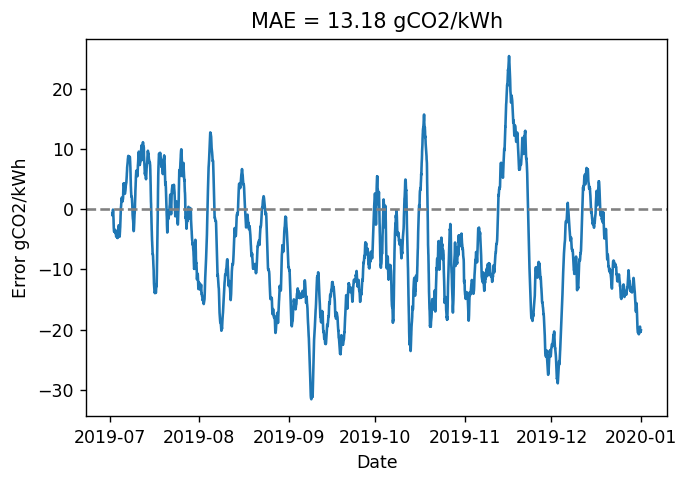

In [11]:
train = df[df.month<=5]
test = df[df.month>5]

X, y = get_X_y(train, feature_cols)

gam = LinearGAM(s(0, n_splines=15) + 
                s(1, n_splines=15) +
                s(2, n_splines=15) +
                s(3, n_splines=15)).fit(X, y)

X_test, y_test = get_X_y(test, feature_cols)
y_pred = gam.predict(X_test)

errors = pd.DataFrame({'error': y_test - y_pred}, index=test.index)

fig, ax = plt.subplots(dpi=125)

ax.plot(errors.error.rolling(100).mean())

ax.axhline(0, color='gray', linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Error gCO2/kWh')

mae = mean_absolute_error(y_test, y_pred)

ax.set_title("MAE = {:.2f} gCO2/kWh".format(mae))

To be fair, the fit is not too bad overall (in terms of MAE), and does not substantially worsen through time. However, we can see that the series is non-stationary, with some periods of systematically under or over-predicting (e.g. around September).

### Monthly Fit

Let's see how performance changes if we fit a new model each month, and predict the following month: 

Month 2: MAE = 12.32 kgCO2/kWh
Month 3: MAE = 9.43 kgCO2/kWh
Month 4: MAE = 13.70 kgCO2/kWh
Month 5: MAE = 13.20 kgCO2/kWh
Month 6: MAE = 28.01 kgCO2/kWh
Month 7: MAE = 18.47 kgCO2/kWh
Month 8: MAE = 13.62 kgCO2/kWh
Month 9: MAE = 13.06 kgCO2/kWh
Month 10: MAE = 10.12 kgCO2/kWh
Month 11: MAE = 14.13 kgCO2/kWh
Month 12: MAE = 10.83 kgCO2/kWh


Text(0.5, 1.0, 'MAE = 14.22 gCO2/kWh')

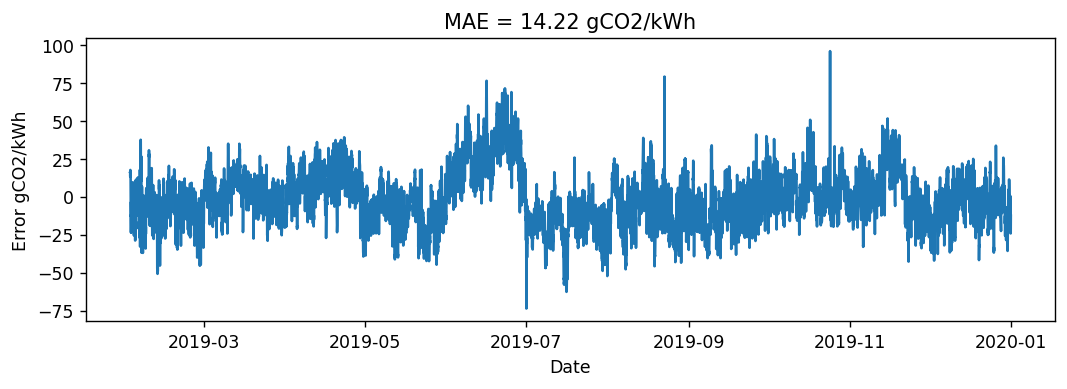

In [12]:
all_dfs = []

for m in df.month.unique()[:-1]:
    
    train = df[df.month==m]
    test = df[df.month==m+1]
    
    X, y = get_X_y(train, feature_cols)
    
    gam = LinearGAM(s(0, n_splines=15) + 
                    s(1, n_splines=15) +
                    s(2, n_splines=15) +
                    s(3, n_splines=15)).fit(X, y)
    
    
    X_test, y_test = get_X_y(test, feature_cols)
    y_pred = gam.predict(X_test)
    
    # Add predictions to a df
    preds_df = pd.DataFrame({'actual': y_test,
                             'pred': y_pred,
                             }, index=test.index)
    all_dfs.append(preds_df)
    
    mae = mean_absolute_error(y_test, y_pred)
    print("Month {}: MAE = {:.2f} kgCO2/kWh".format(m+2, mae))
    
# Concatenate all preds
preds_df = pd.concat(all_dfs)
fig, ax = plt.subplots(dpi=125, figsize=(10,3))
ax.plot(preds_df.actual - preds_df.pred)

mae = mean_absolute_error(preds_df.actual, preds_df.pred)

ax.set_xlabel('Date')
ax.set_ylabel('Error gCO2/kWh')
ax.set_title("MAE = {:.2f} gCO2/kWh".format(mae))


### Plotting the carbon intensity curve

Finally let's see what 

In [13]:
def hour_to_sin_cos(hour):
    """
    Convert hour (int) to sin and cos projection
    """
    sin_hour = np.sin(2*np.pi*hour / 24)
    cos_hour = np.cos(2*np.pi*hour / 24)
    
    return sin_hour, cos_hour

In [14]:
def predict_gCO2(gam, state, net_demands):
    """
    Predict carbon intensity given a fitted GAM, defined fixed state variables (dict)
    and net demands (array)
    """
    
    assert 'net_demand' in state.keys()
    
    state = pd.Series(state).astype(float)
    
    X = state.values
    X_rep = np.tile(X, (len(net_demands),1))
    X_rep[:, 0] = net_demands
    
    preds = gam.predict(X_rep)
    ints = gam.prediction_intervals(X_rep)
    
    return preds, ints
    

In [17]:
hour = 10
wind = 5
N = 100
sin_hour, cos_hour = hour_to_sin_cos(hour)

state = {'net_demand': np.nan,
     'sin_hour': sin_hour,
     'cos_hour': cos_hour,
     'wind': wind}

net_demands = np.linspace(10, 40, N)

preds, ints = predict_gCO2(gam, state, net_demands)

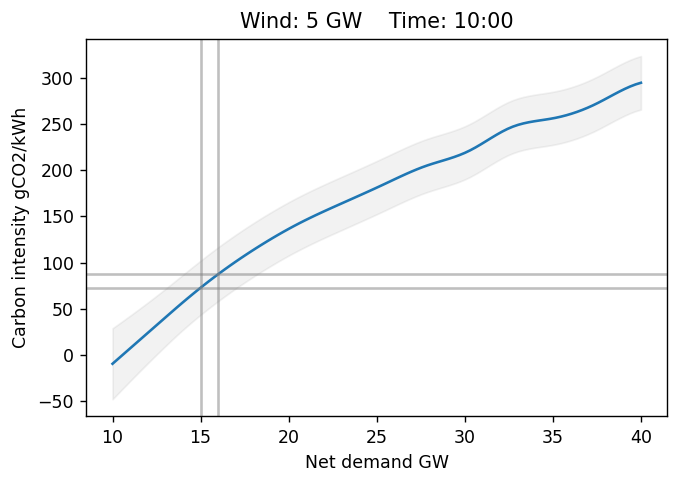

In [19]:
fig, ax = plt.subplots(dpi=125)

ax.plot(net_demands, preds)
ax.fill_between(net_demands, ints[:,0], ints[:,1], color='grey', alpha=0.1)

ax.set_xlabel("Net demand GW")
ax.set_ylabel("Carbon intensity gCO2/kWh")

ax.set_title("Wind: {} GW    Time: {}:00".format(wind, hour))

lwr = 15
upr = 16

y1 = predict_gCO2(gam, state, np.array([lwr]))[0]
y2 = predict_gCO2(gam, state, np.array([upr]))[0]

a = 0.5
c = 'gray'
ax.axvline(lwr, color=c, alpha=a)
ax.axvline(upr, color=c, alpha=a)

ax.axhline(y1, color=c, alpha=a)
ax.axhline(y2, color=c, alpha=a)

plt.savefig('img/example_curve.png')